# Amazon Fine Food Reviews Analysis

#### Objective:

In [50]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [51]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 6000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x<3:
        return 0
    return 1
#changing reviews with score less than 3 to be negative and vice-versa
actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']=positiveNegative
print("The no of datapoints in our data", filtered_data.shape)
filtered_data.head(5)
    

The no of datapoints in our data (6000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [52]:
display=pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
Group by UserId
Having count(*)>1
""",con)

In [53]:
print(display.shape)
display.head(5)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [54]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [55]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False ,kind='quicksort', na_position='last')

In [56]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first',inplace=False)
final.shape

(5979, 10)

In [57]:
#Checking to see how much % of data still remains
final['Id'].size*1.0/(filtered_data['Id'].size*1.0)*100

99.65

 # Observation 
 It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [58]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [59]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [60]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(5979, 10)


1    5014
0     965
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [61]:
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [62]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [63]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)# remove urls from text python
    sentence = BeautifulSoup(sentence, 'lxml').get_text() #to-remove-all-tags-from-an-element
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()#remove words with numbers python
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)#remove special character
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████████| 5979/5979 [00:01<00:00, 3042.48it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [64]:
#Bow
count_vect=CountVectorizer()#Scikit learn
count_vect.fit(preprocessed_reviews)
print("some feature names ",count_vect.get_feature_names()[:10])
print("="*100)
final_counts=count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 14318)
the number of unique words  14318


## [4.2] Bi-Grams and n-Grams.

In [65]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=6000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 3711)
the number of unique words  3711


## [4.3] TF-IDF

In [66]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely delicious']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5979, 3711)
the number of unique words including both unigrams and bigrams  3711


In [67]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())
w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('good', 0.9815202355384827), ('excellent', 0.9774333238601685), ('regular', 0.9774311184883118), ('alternative', 0.9742913246154785), ('think', 0.9740332961082458), ('pronounced', 0.9722665548324585), ('enjoy', 0.9718561768531799), ('licorice', 0.9709137678146362), ('salty', 0.9704329371452332), ('greasy', 0.9702098965644836)]
[('wow', 0.9986859560012817), ('jalapeno', 0.9986807107925415), ('oatmeal', 0.9985789060592651), ('cravings', 0.9985335469245911), ('miss', 0.9985299706459045), ('sense', 0.9985092878341675), ('doubt', 0.9985024929046631), ('superior', 0.9984349012374878), ('course', 0.9984083771705627), ('fantastic', 0.9983918070793152)]


In [68]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4278
sample words  ['product', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'seasons', 'ca', 'not', 'beat', 'great', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [21]:
# average Word2Vec
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5979/5979 [00:18<00:00, 329.75it/s]

5979
50


#### [4.4.1.2] TFIDF weighted W2v

In [22]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5979/5979 [01:23<00:00, 71.51it/s]


## [5.1] Applying TNSE on Text BOW vectors

In [28]:
#TSNE
# As BoW and TF-IDF gives sparse matrix, and TSNE only accepts Dense matrix.so we need to convert sparse matrix to dense
from sklearn.preprocessing import StandardScaler
print(final_counts.shape)
std_data = StandardScaler(with_mean = False).fit_transform(final_counts)
print(std_data.shape)
type(std_data)
std_data=std_data.todense()
print(type(std_data))



(5979, 14318)
(5979, 14318)
<class 'numpy.matrix'>


Text(0.5, 1.0, 'TSNE for Bag of Words')

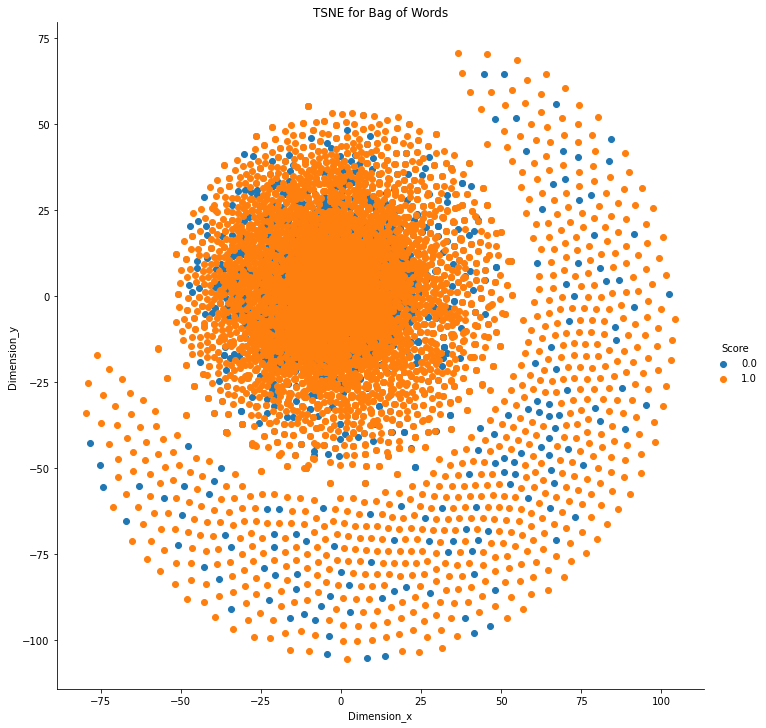

In [34]:
score=final['Score']
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = 1000, random_state=0)

for_tsne = model.fit_transform(std_data)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", height=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for Bag of Words")

## [5.1] Applying TNSE on Text TFIDF vectors

In [69]:
print(final_counts.shape)
std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print(std_data.shape)
type(std_data)
std_data=std_data.todense()
print(type(std_data))

(5979, 14318)
(5979, 3711)
<class 'numpy.matrix'>


Text(0.5, 1.0, 'TSNE for TF-IDF')

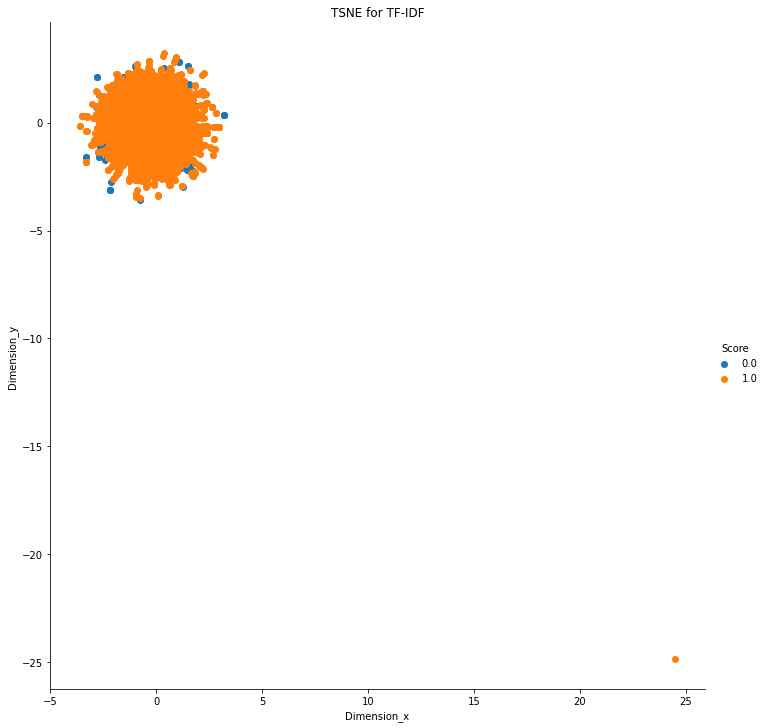

In [70]:
model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = 1000, random_state=0)

for_tsne = model.fit_transform(std_data)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", height=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for TF-IDF")

## [5.3] Applying TNSE on Text Avg W2V vectors

In [40]:
from sklearn.preprocessing import StandardScaler
print(final_counts.shape)
std_data1 = StandardScaler(with_mean = False).fit_transform(sent_vectors)
print(std_data1.shape)
type(std_data1)
print(type(std_data1))

(5979, 14318)
(5979, 50)
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'TSNE for W2Vec')

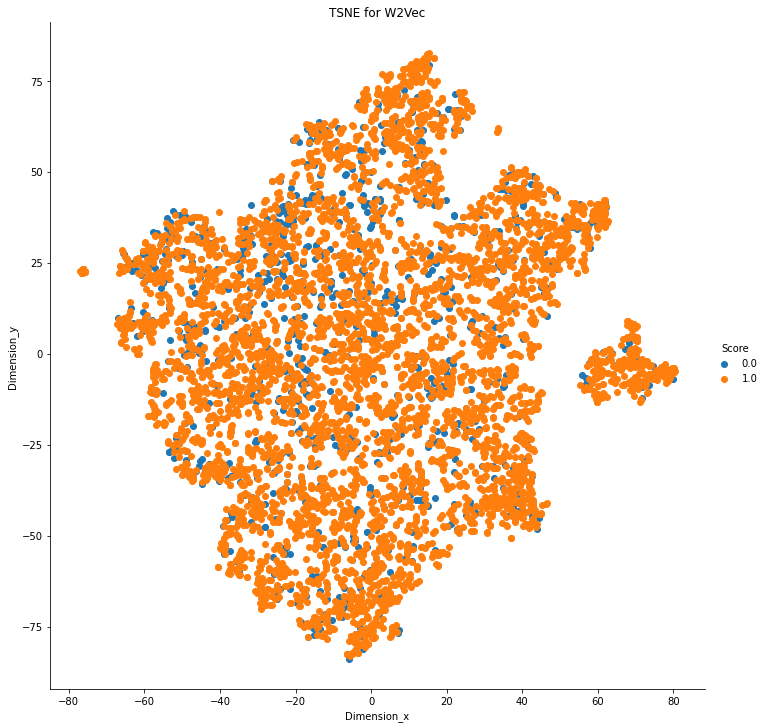

In [42]:
model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = 1000, random_state=0)

for_tsne = model.fit_transform(std_data1)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", height=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for W2Vec")

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [43]:
from sklearn.preprocessing import StandardScaler
print(final_counts.shape)
std_data2 = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
print(std_data2.shape)
type(std_data2)
print(type(std_data2))

(5979, 14318)
(5979, 50)
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'TSNE for TFIDF weighted W2V vectors')

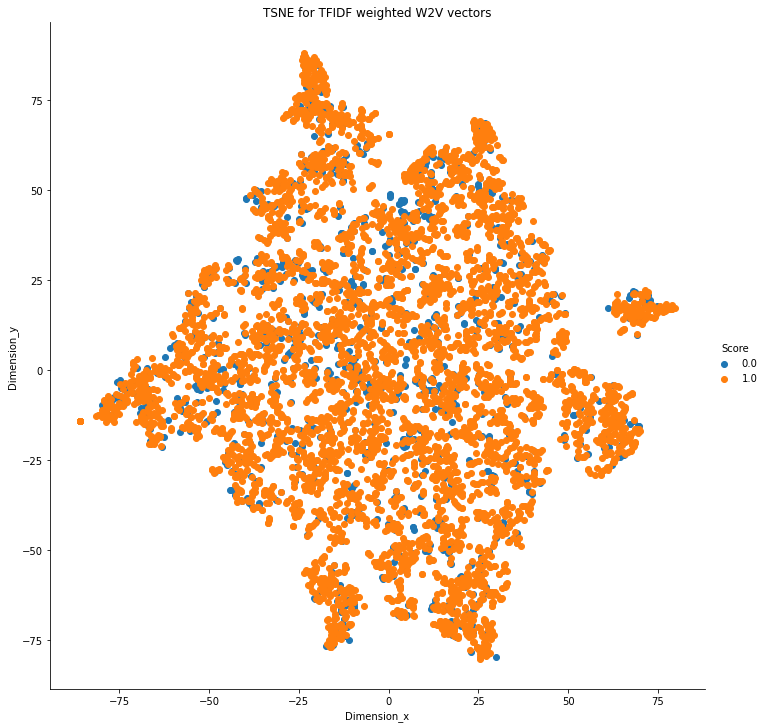

In [46]:
model = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = 1000, random_state=0)

for_tsne = model.fit_transform(std_data2)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", height=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for TFIDF weighted W2V vectors")

# observation

# [6] Conclusions